# Import Library

In [1]:
# Standard Libraries
import datetime
import json
import os
import pickle
import random
import shutil
import zipfile
from pathlib import Path

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Image Processing
import cv2
from PIL import Image
from skimage import img_as_ubyte, io
from skimage.exposure import adjust_gamma
from skimage.transform import AffineTransform, resize, rotate, warp
from skimage.util import random_noise

# Progress Bar
from tqdm import tqdm
from tqdm.notebook import tqdm as tq

# Deep Learning - TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import TFSMLayer

# TensorFlow Keras Modules
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import (
    DenseNet121,
    EfficientNetB4,
    InceptionV3,
    MobileNet,
    MobileNetV2
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    Callback
)
from tensorflow.keras.layers import (
    Input,
    InputLayer,
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory

# Data Augmentation - Albumentations
from albumentations import (
    Affine,
    Blur,
    CLAHE,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    OneOf,
    RandomBrightnessContrast,
    RandomGamma,
    Resize,
    VerticalFlip
)

# Sklearn Utilities
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Platform Integration (Kaggle & Colab)
import kagglehub
from google.colab import files

Mengabaikan peringatan

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Load Dataset

Mengunduh dataset dari kaggle

In [3]:
path = kagglehub.dataset_download("dipoyonoarga/dataset-singkong")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dataset-singkong


Memindahkan dataset ke writable folder

In [4]:
src = path
dst = '/content/Dataset'

if not os.path.exists(dst):
    shutil.copytree(src, dst)

Mendefinisikan path ke dataset dan daftar kelas

In [5]:
dataset_path = '/content/Dataset/Dataset-Singkong'
classes = os.listdir(dataset_path)

# Mengecek isi dataset
print(classes)

['Cassava___mosaic_disease', 'Cassava___healthy', 'Cassava___brown_streak_disease', 'Cassava___bacterial_blight', 'Cassava___green_mottle']


Mengecek gambar dari setiap kelas

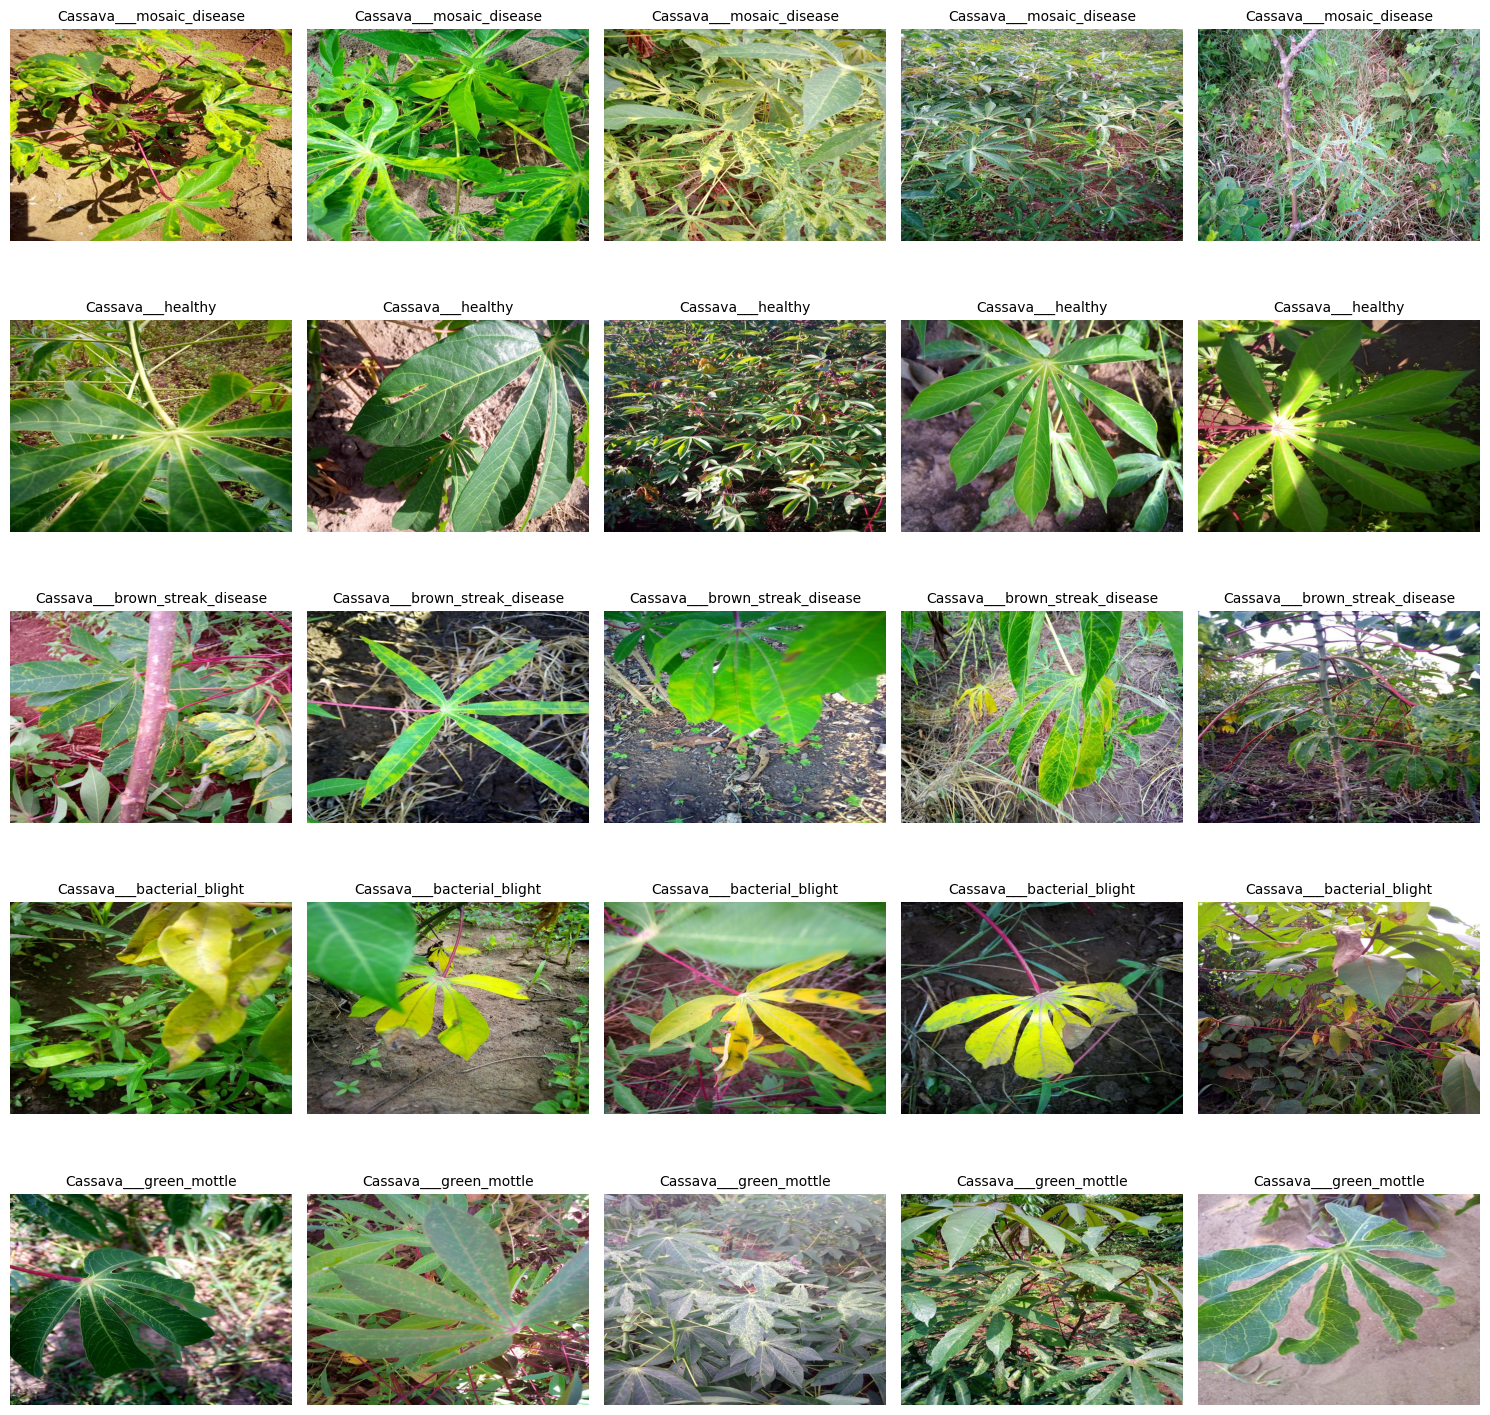

In [6]:
# Setup plot dengan ukuran yang dinamis berdasarkan jumlah kelas
plt.figure(figsize=(15, 3 * len(classes)))

# Loop melalui setiap kelas
for class_index, disease_class in enumerate(classes):
    class_folder_path = os.path.join(dataset_path, disease_class)
    image_files = os.listdir(class_folder_path)[:5]  # Ambil 5 gambar pertama

    # Loop melalui setiap gambar dalam kelas
    for image_index, image_file in enumerate(image_files):
      full_image_path = os.path.join(class_folder_path, image_file)

      # Menyipkan posisi subplot
      subplot_position = class_index * 5 + image_index + 1
      plt.subplot(len(classes), 5, subplot_position)

      # Menampilkan gambar
      plt.imshow(Image.open(full_image_path))
      plt.title(disease_class, fontsize=10)
      plt.axis('off')

plt.tight_layout()
plt.show()

Mengecek distribusi data

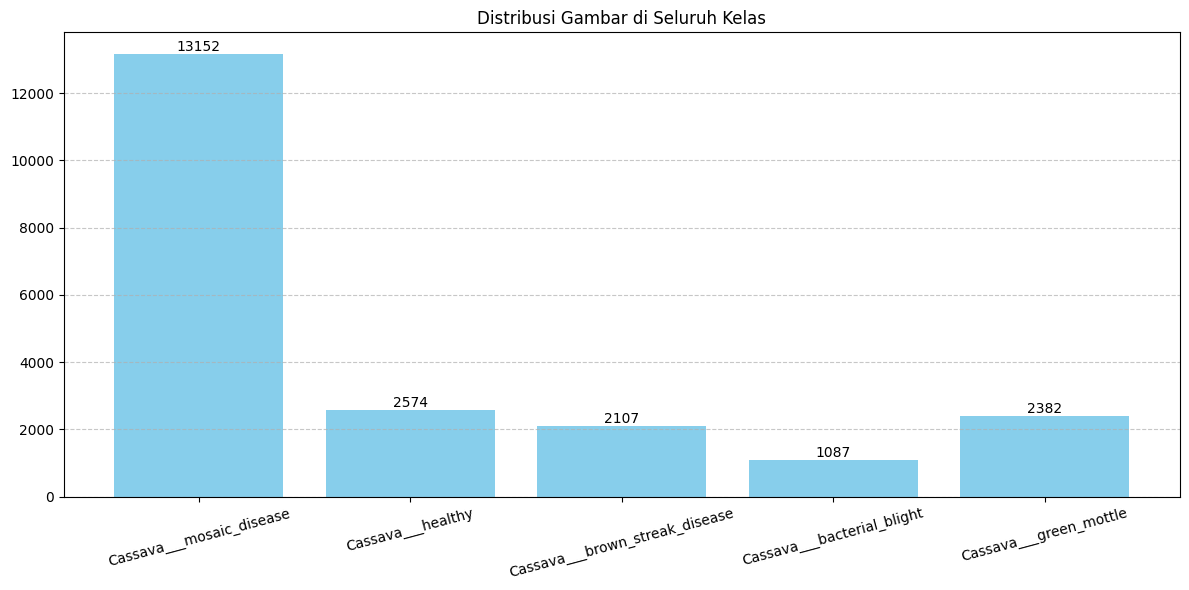

In [7]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preparation

Melakukan Under sampling untuk mengatasi imbalance dataset

In [8]:
base_folder_path = dataset_path
target_count_per_class = 2574

for class_name in classes:
    folder_path = os.path.join(base_folder_path, class_name)
    if os.path.isdir(folder_path):
        all_files = os.listdir(folder_path)
        random.shuffle(all_files)

        if len(all_files) > target_count_per_class:
            files_to_keep = set(all_files[:target_count_per_class])
            files_to_remove = [file for file in all_files if file not in files_to_keep]

            print(f"Mengurangi jumlah file di '{class_name}': Menghapus {len(files_to_remove)} file.")
            for file in files_to_remove:
                os.remove(os.path.join(folder_path, file))
        else:
            print(f"Jumlah file di '{class_name}' ({len(all_files)}) sudah kurang dari atau sama dengan target ({target_count_per_class}). Tidak ada file yang dihapus.")

# Verifikasi setelah pengurangan
print("\nJumlah file per kelas setelah pengurangan:")
imageCount_after = {class_name: len(os.listdir(os.path.join(base_folder_path, class_name))) for class_name in classes if os.path.isdir(os.path.join(base_folder_path, class_name))}
for class_name, count in imageCount_after.items():
    print(f"{class_name}: {count}")

Mengurangi jumlah file di 'Cassava___mosaic_disease': Menghapus 10578 file.
Jumlah file di 'Cassava___healthy' (2574) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___brown_streak_disease' (2107) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___bacterial_blight' (1087) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___green_mottle' (2382) sudah kurang dari atau sama dengan target (2574). Tidak ada file yang dihapus.

Jumlah file per kelas setelah pengurangan:
Cassava___mosaic_disease: 2574
Cassava___healthy: 2574
Cassava___brown_streak_disease: 2107
Cassava___bacterial_blight: 1087
Cassava___green_mottle: 2382


Mengecek hasil undersampling pada dataset

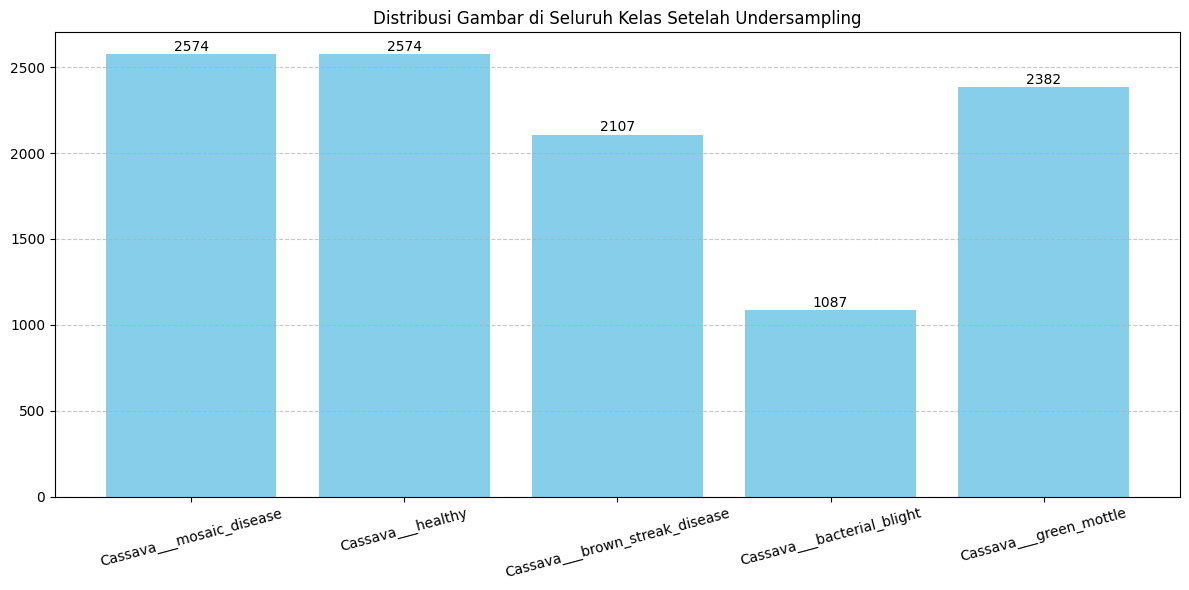

In [9]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas Setelah Undersampling")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Split dataset

In [11]:
def split_dataset_folder(base_dir, output_dir, train_size=0.75, val_size=0.15, test_size=0.1):
    assert round(train_size + val_size + test_size, 2) == 1.0, "Split ratio harus 1.0 total"

    classes = os.listdir(base_dir)

    for split in ['train', 'valid', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_size * n_total)
        n_val = int(val_size * n_total)

        train_files = images[:n_train]
        val_files = images[n_train:n_train + n_val]
        test_files = images[n_train + n_val:]

        for file_set, split in zip([train_files, val_files, test_files], ['train', 'valid', 'test']):
            for file in file_set:
                src = os.path.join(cls_path, file)
                dst = os.path.join(output_dir, split, cls, file)
                shutil.copy(src, dst)

# Contoh penggunaan
split_dataset_folder(
    base_dir='/content/Dataset/Dataset-Singkong',
    output_dir='/content/Dataset/Split-Dataset',
    train_size=0.8,
    val_size=0.1,
    test_size=0.1
)

Mengecek jumlah data pada train set

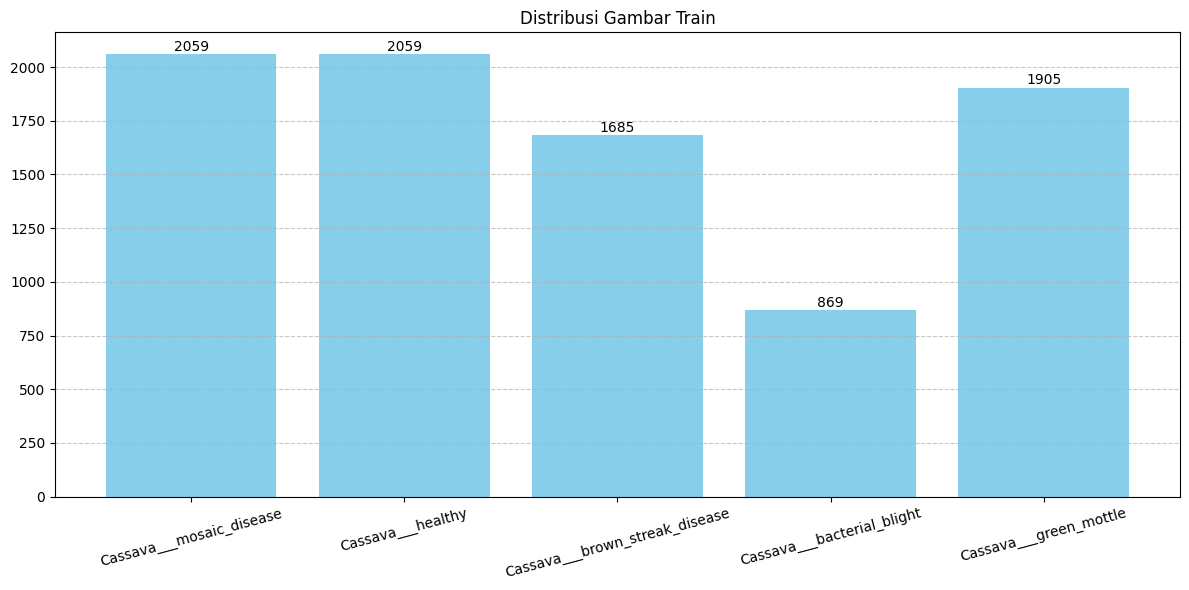

In [12]:
train_path = '/content/Dataset/Split-Dataset/train'
imageCount = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar Train")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Membuat data generator untuk train dan validation

In [26]:
def train_val_generators_from_directory(base_dir):

    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        preprocessing_function = None,
        zoom_range = 0.2,
        cval = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 5,
        fill_mode = 'constant',
        shear_range = 0.2,
        height_shift_range = 0.2,
        width_shift_range = 0.2
    )

    train_generator = datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'train'),
        target_size=(299, 299),
        batch_size=16,
        class_mode='sparse',
        shuffle=True,
        seed=42
    )

    val_generator = datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'valid'),
        target_size=(299, 299),
        batch_size=16,
        class_mode='sparse',
        shuffle=False
    )

    return train_generator, val_generator

train_generator, val_generator = train_val_generators_from_directory("/content/Dataset/Split-Dataset")

Found 8577 images belonging to 5 classes.
Found 1070 images belonging to 5 classes.


Membuat data generator untuk test

In [27]:
def test_generator_from_directory(base_dir):
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    test_generator = test_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'test'),
        target_size=(299, 299),
        batch_size=16,
        class_mode='sparse',
        shuffle=False
    )

    return test_generator

test_generator = test_generator_from_directory("/content/Dataset/Split-Dataset")

Found 1077 images belonging to 5 classes.


Menambahkan class weight untuk menangani imbalance pada dataset

In [28]:
# Ambil semua label dari train_generator
labels = train_generator.classes
class_indices = train_generator.class_indices
num_classes = len(class_indices)

# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Ubah ke format dictionary untuk fit()
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.9739930955120828), 1: np.float64(1.0180415430267062), 2: np.float64(0.9004724409448819), 3: np.float64(0.8331228751821272), 4: np.float64(0.8331228751821272)}


# Model Development

Membangun model

In [29]:
def build_model():
    model = models.Sequential()

    model.add(EfficientNetB4(
        include_top=False,
        weights='imagenet',
        input_shape=(299, 299, 3)
    ))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5, name='dropout'))
    model.add(layers.Dense(5, activation='softmax', name='dense_output'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inisialisasi model baru
model = build_model()

# Simpan bobot awal
initial_weights = model.get_weights()

# Reset model ke kondisi awal sebelum fit
model.set_weights(initial_weights)

Melihat arsitektur model

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 10, 10, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,682,788 (67.45 MB)

 Trainable params: 17,557,581 (66.98 MB)

 Non-trainable params: 125,207 (489.09 KB)

Membuat callback

In [31]:
class AccuracyThresholdCallback(Callback):
    def __init__(self, train_acc=0.96, val_acc=0.96):
        super(AccuracyThresholdCallback, self).__init__()
        self.train_acc = train_acc
        self.val_acc = val_acc

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy is not None and val_accuracy is not None:
            if train_accuracy >= self.train_acc and val_accuracy >= self.val_acc:
                print("Training model dihentikan karena model telah mencapai target akurasi")
                self.model.stop_training = True

# Callback untuk menghentikan model jika val_loss tidak membaik
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=2
)

Melatih model

In [32]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1,
    class_weight = class_weight_dict,
    callbacks=[early_stop, AccuracyThresholdCallback(train_acc=0.96, val_acc=0.96), reduce_lr]
)

Epoch 1/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 490s 635ms/step - accuracy: 0.4366 - loss: 1.2999 - val_accuracy: 0.3355 - val_loss: 1.6425 - learning_rate: 1.0000e-04
Epoch 2/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 283s 526ms/step - accuracy: 0.6645 - loss: 0.8795 - val_accuracy: 0.6701 - val_loss: 0.9192 - learning_rate: 1.0000e-04
Epoch 3/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 270s 502ms/step - accuracy: 0.7218 - loss: 0.7238 - val_accuracy: 0.6318 - val_loss: 1.0406 - learning_rate: 1.0000e-04
Epoch 4/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 268s 499ms/step - accuracy: 0.7536 - loss: 0.6723 - val_accuracy: 0.5252 - val_loss: 1.2095 - learning_rate: 1.0000e-04
Epoch 5/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7704 - loss: 0.6199
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
537/537 ━━━━━━━━━━━━━━━━━━━━ 267s 496ms/step - accuracy: 0.7704 - loss: 0.6198 - val_accuracy: 0.5645 - val_loss: 1.1853 - learning_rate: 1.0000e-04
Epoch 6/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 264s 49

# Evaluation

Mengecek performa model pada test set

In [33]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.6822 - loss: 0.9619

Test Accuracy: 0.7419
Test Loss: 0.7692


Mengecek perkembangan performa model dengan grafik

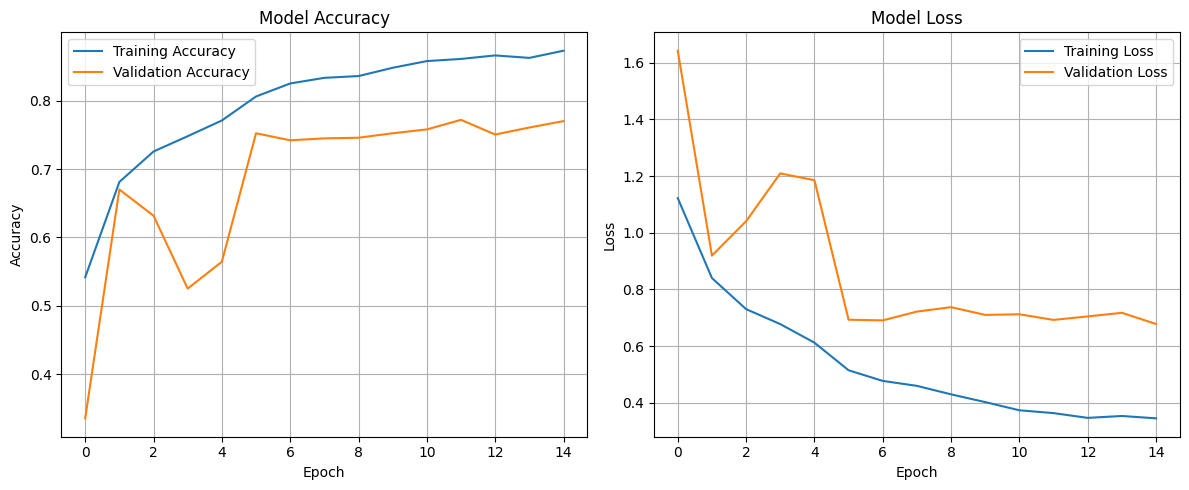

In [34]:
def plot_model_performance(history):
    # Akurasi
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_model_performance(history)

Mengecek performa model dengan laporan klasifikasi

In [35]:
# Prediksi pada test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Ambil kelas prediksi

# Label asli
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 254ms/step
Classification Report:

                                precision    recall  f1-score   support

    Cassava___bacterial_blight       0.62      0.55      0.58       110
Cassava___brown_streak_disease       0.76      0.75      0.76       212
        Cassava___green_mottle       0.85      0.67      0.75       239
             Cassava___healthy       0.61      0.79      0.69       258
      Cassava___mosaic_disease       0.86      0.83      0.85       258

                      accuracy                           0.74      1077
                     macro avg       0.74      0.72      0.73      1077
                  weighted avg       0.76      0.74      0.74      1077



Mengecek performa model dengan confussion matrix

68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step


<Figure size 800x600 with 0 Axes>

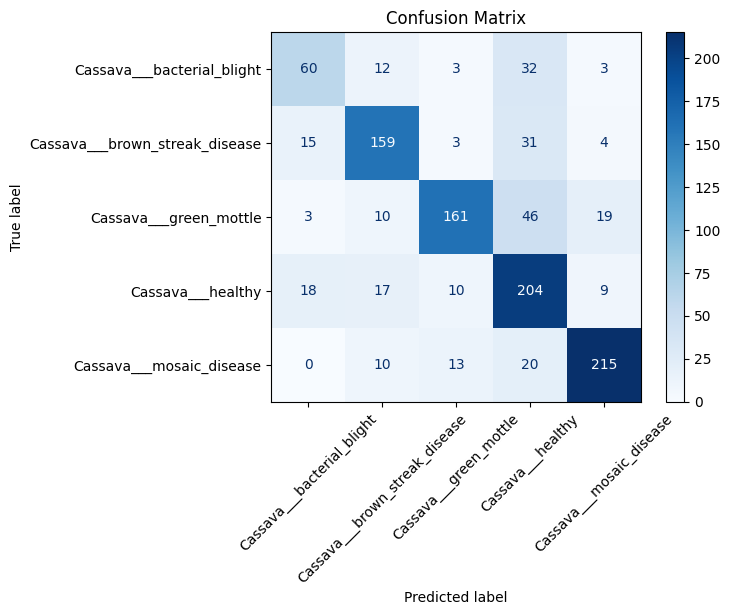

In [36]:
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

Inference testing dengan gambar dari testing set

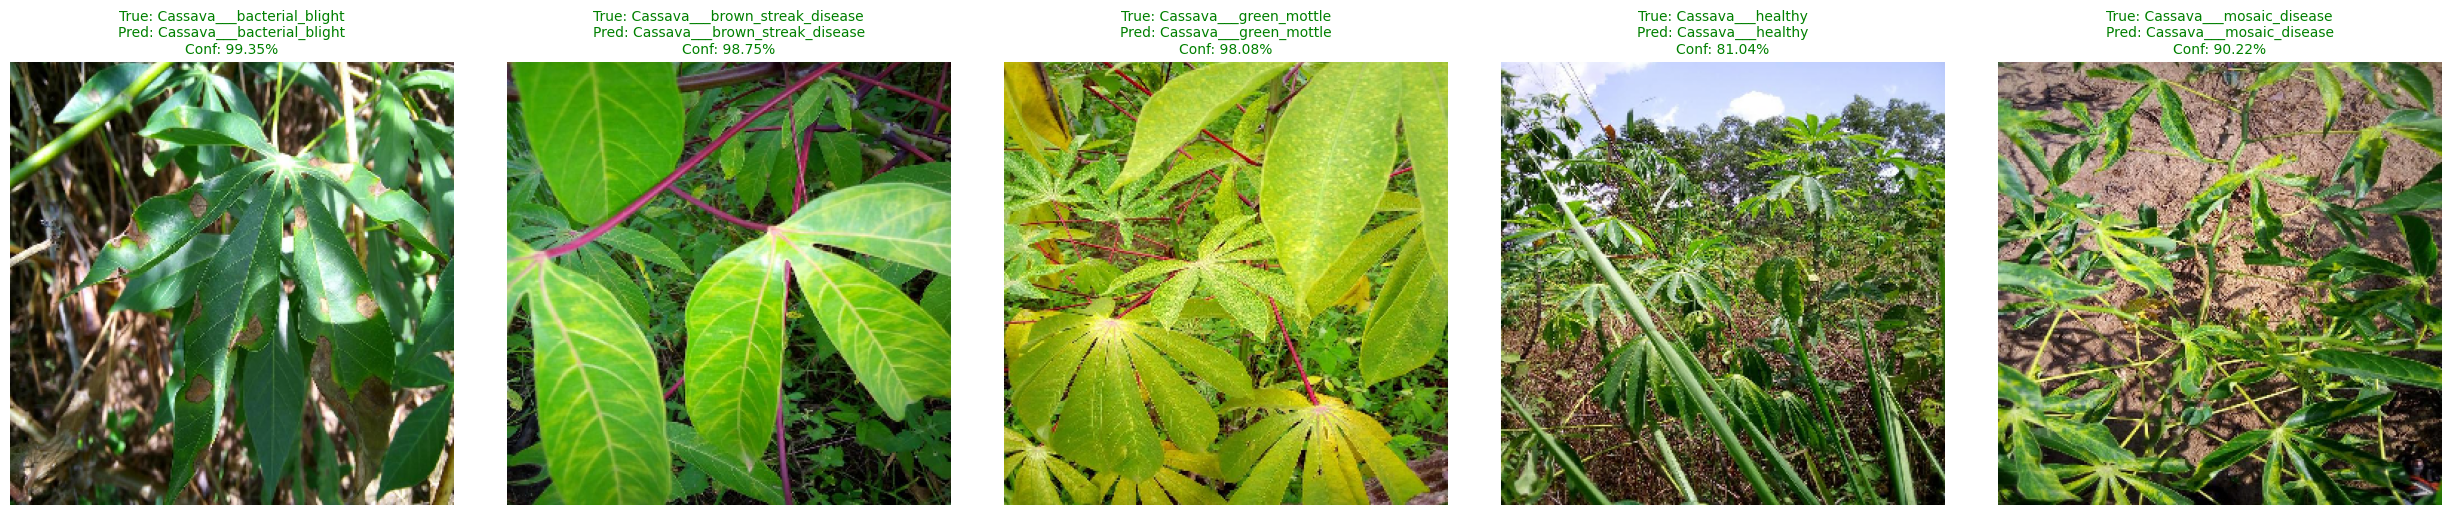

In [37]:
def predict_sample_images(test_dir, model, target_size=(299, 299), class_indices=None):
    inverse_class_indices = {v: k for k, v in class_indices.items()}

    class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    num_classes = len(class_names)

    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    if num_classes == 1:
        axes = [axes]  # jika hanya satu kelas

    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(test_dir, class_name)
        image_list = os.listdir(class_folder)
        if not image_list:
            continue

        # Ambil satu gambar secara acak
        image_name = random.choice(image_list)
        img_path = os.path.join(class_folder, image_name)

        # Preprocess gambar
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0
        img_array_exp = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array_exp, verbose=0)
        pred_index = np.argmax(prediction)
        pred_label = inverse_class_indices[pred_index]
        confidence = prediction[0][pred_index] * 100

        # Visualisasi
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"True: {class_name}\nPred: {pred_label}\nConf: {confidence:.2f}%",
            color='green' if pred_label == class_name else 'red',
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

test_dir = "/content/Dataset/Split-Dataset/test"
predict_sample_images(
    test_dir=test_dir,
    model=model,  # model yang sudah Anda latih
    target_size=(299, 299),
    class_indices=test_generator.class_indices  # pakai dari test_generator
)

Inference testing dengan gambar yang diberikan oleh user

Saving bacterial_blight.jpg to bacterial_blight.jpg


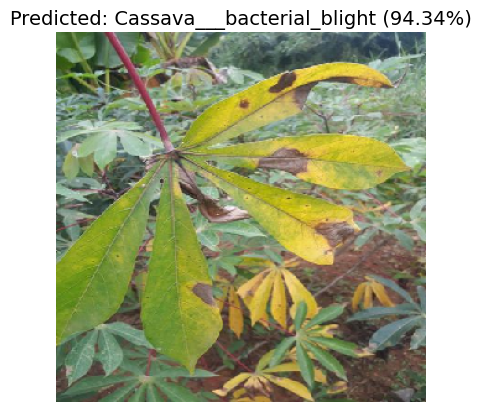

In [38]:
def predict_uploaded_image(model, class_indices, target_size=(299, 299)):
    # Upload file
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Load dan preprocess gambar
        img = image.load_img(filename, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0
        img_array_exp = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array_exp, verbose=0)
        pred_index = np.argmax(prediction)
        confidence = prediction[0][pred_index] * 100

        # Konversi indeks ke label kelas
        inverse_class_indices = {v: k for k, v in class_indices.items()}
        predicted_label = inverse_class_indices[pred_index]

        # Tampilkan hasil
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)", fontsize=14)
        plt.show()

predict_uploaded_image(model, class_indices=test_generator.class_indices)

# Convert and Save Model

Mempersiapkan folder untuk menampung model

In [39]:
os.makedirs("saved_model", exist_ok=True)
os.makedirs("tfjs_model", exist_ok=True)
os.makedirs("pkl_model", exist_ok=True)

Menyimpan model dama format savedmodel

In [40]:
model.export('/content/saved_model/')

Saved artifact at '/content/saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_956')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137282846221392: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137282846223504: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137283999917328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903602384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903600464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903602576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903590480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903601424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903601040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137282903599696: TensorSpec(shape=(), dtype=tf.resource, 

Menyimpan model dalam format TFJSModel

In [41]:
!pip install tensorflowjs

saved_model_loc = "/content/saved_model/"
# Konversi ke format TensorFlow.js dari SavedModel
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    {saved_model_loc} /content/tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-06-07 16:35:10.068401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749314110.100960   47736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

Menyimpan model dalam format pkl

In [42]:
save_dir = '/content/pkl_model'
model.save(os.path.join(save_dir, 'model_cassava.h5'))
with open(os.path.join(save_dir, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

Melakukan zip pada model yang telah disimpan untuk mempermudah proses download

In [43]:
folders_to_zip = ['pkl_model', 'saved_model', 'tfjs_model']
output_zip_path = 'exported_models.zip'

with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in folders_to_zip:
        for root, dirs, files in os.walk(folder):
            for file in files:
                filepath = os.path.join(root, file)
                arcname = os.path.relpath(filepath, start=os.path.dirname(folder))
                zipf.write(filepath, arcname)

In [44]:
test_generator.class_indices

{'Cassava___bacterial_blight': 0,
 'Cassava___brown_streak_disease': 1,
 'Cassava___green_mottle': 2,
 'Cassava___healthy': 3,
 'Cassava___mosaic_disease': 4}